# Parameters

# Generate data

In [1]:
import numpy as np
import pandas as pd
from Models import baseline_raw_model, baseline_ribba_hyperparams, initial_tuple_ribba
from therapy import Therapy, gliomas_strategy
from utils import plot_ribba_model_results

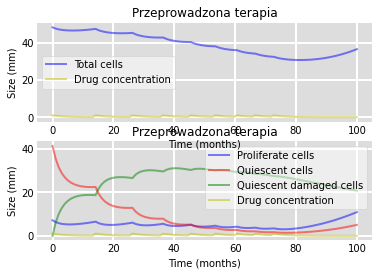

In [2]:
time_range = np.linspace(0, 100, 100)

therapy = Therapy(baseline_raw_model, gliomas_strategy)
therapy.compute_therapy(time_range, initial_tuple_ribba)
res = therapy.results

P, Q, Qp, C = [res[i] for i in ["P", "Q", "Qp", "C"]]
df = pd.DataFrame(np.array([P, Q, Qp]).T, columns=["P", "Q", "Qp"])

plot_ribba_model_results(res, time_range, "Przeprowadzona terapia")

# ESN model preparation

In [3]:
!pip3 install auto-esn==0.0.7
!pip3 install torch

You should consider upgrading via the '/Users/jakub/.asdf/installs/python/3.9.9/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/jakub/.asdf/installs/python/3.9.9/bin/python3 -m pip install --upgrade pip' command.


In [4]:
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import auto_esn.utils.dataset_loader as dl
from auto_esn.datasets.df import MackeyGlass
from auto_esn.esn.esn import GroupedDeepESN,DeepESN
from auto_esn.esn.reservoir.util import NRMSELoss
from auto_esn.esn.reservoir.activation import tanh

In [15]:
TEST_SIZE_RATIO = 0.4

def select_train_and_test(data_frame, ratio=TEST_SIZE_RATIO):
    datas = [[] for _ in range(4)]
    for col in data_frame:
        col_df = pd.DataFrame(data=data_frame[col].tolist(), columns=['y'])
        _X, _X_test, _y, _y_test = dl.loader_explicit(col_df, test_size=int(data_frame.shape[0] * ratio))()
        datas[0].append(_X)
        datas[1].append(_X_test)
        datas[2].append(_y)
        datas[3].append(_y_test)
    X, X_test, y, y_test = [torch.cat((data), dim=1) for data in datas]
    
    return X, X_test, y, y_test


# Training

In [16]:
def extrapolate(esn, X_test, y_test):
    training_size = X_test.size()[0]
  
    val = X_test[0:1]
    result = []
    for j in range(training_size):
        val = esn(val)
        result.append(val)
  
    res = torch.vstack(result)

    return res

def merge_base_with_extrapolated(X, y, y_test, extrapolated):
    training_size = y_test.size()[0]
    
    predicted = np.vstack([X.detach().numpy()[-training_size:,:], extrapolated.detach().numpy()])
    true = np.vstack([y.detach().numpy()[-training_size:,:], y_test.detach().numpy()])
    
    return predicted, true

# Results

In [17]:
def plot_results(title, size, expected, calculated, separator_at=None):
    
    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(18.5, 10.5)
    fig.suptitle(title, fontsize=16)

    for idx, param in enumerate(["P", "Q", "Qp"]):
        ax = axs[idx // 2, idx % 2]

        ax.plot(range(size), calculated[:,idx], 'r', label=f'predicted - {param}')
        ax.plot(range(size), expected[:,idx], 'b', label='true')
        if separator_at is not None: 
            ax.axvline(x = separator_at, color = 'g', label = 'extrapolation')
        ax.legend()
    plt.show()

In [36]:
def test_esn_mse(esn, X_test, y_test):
    output = esn(X_test)
    
    return ((output - y_test)**2).mean(axis=0).detach().numpy()

def plot_mse(x_range, errors, title, x_label):
    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(10, 6)
    fig.suptitle(title, fontsize=16)
    errors = np.array(errors).T

    for idx, param in enumerate(["P", "Q", "Qp"]):
        ax = axs[idx // 2, idx % 2]
        ax.plot(x_range, errors[idx], label=f"Param {param}")
        ax.set_xlabel(x_label)
        ax.set_ylabel("MSE")
        ax.legend()
    plt.show()
        
def plot_esn_prediction(esn, X, y, offset=0):
    predicted = esn(X)
    x_range = range(offset, X.size()[0] + offset)
    plt.xlabel("Dzień terapii")
    plt.ylabel("Wielkość guza")
    
    plt.plot(x_range, y.T[0], label="P", color="#e83613")
    plt.plot(x_range, predicted.T[0], label="P - predykcja", color="#f7826a")
    
    plt.plot(x_range, y.T[1], label="Q", color="#0526fa")
    plt.plot(x_range, predicted.T[1], label="Q - predykcja", color="#5467e3")
    
    plt.plot(x_range, y.T[2], label="Qp", color="#147303")
    plt.plot(x_range, predicted.T[2], label="Qp - predykcja", color="#4ffc30")

    
    plt.legend()
    plt.show()

    

In [37]:
X, X_test, y, y_test = select_train_and_test(df)

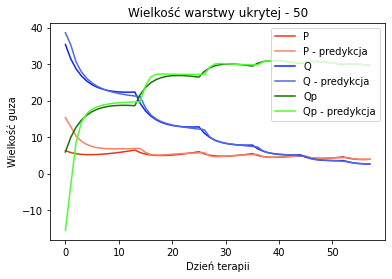

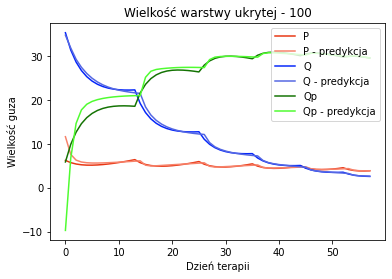

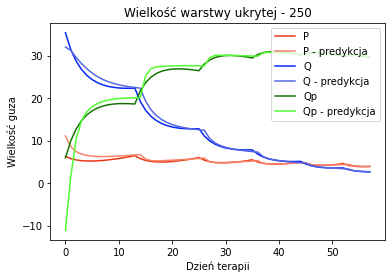

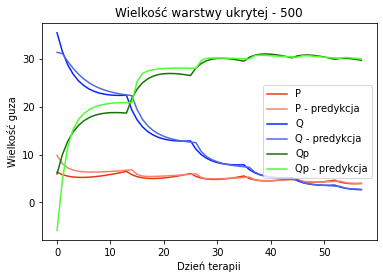

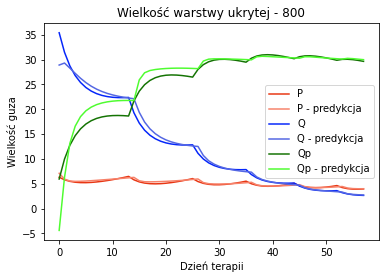

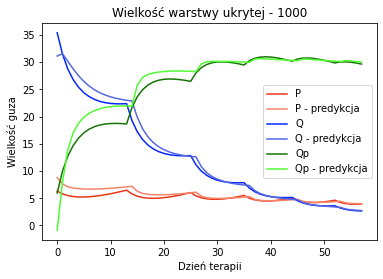

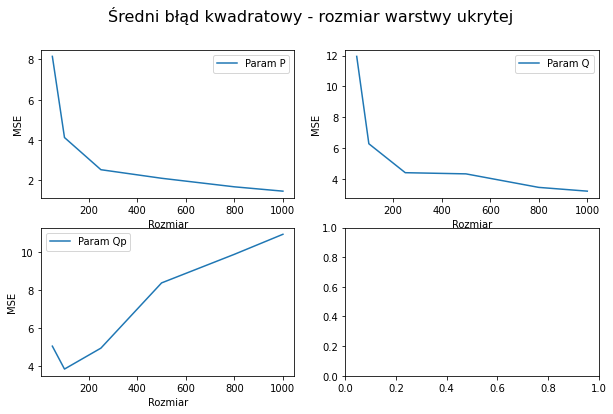

In [38]:
errors = []
total_layers = [50, 100, 250, 500, 800, 1000]
for hidden_size in total_layers: 
    esn = DeepESN(input_size=3, num_layers=3, hidden_size=hidden_size)
    esn.fit(X, y)
    errors.append(test_esn_mse(esn, X_test, y_test))
    
    esn = DeepESN(input_size=3, num_layers=3, hidden_size=hidden_size)
    esn.fit(X, y)
    
    plt.title(f"Wielkość warstwy ukrytej - {hidden_size}")
    plot_esn_prediction(esn, X, y)

plot_mse(total_layers, errors, "Średni błąd kwadratowy - rozmiar warstwy ukrytej", "Rozmiar")    

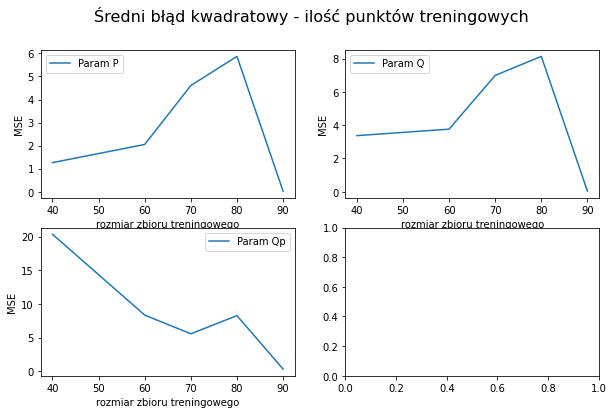

In [46]:
errors = []
ratios = [0.6, 0.4, 0.3, 0.2, 0.1]
for ratio in ratios:
    X, X_test, y, y_test = select_train_and_test(df, ratio)
    esn = DeepESN(input_size=3, num_layers=3, hidden_size=500)
    esn.fit(X, y)
    errors.append(test_esn_mse(esn, X_test, y_test))
    # esn = DeepESN(input_size=3, num_layers=3)
    # esn.fit(X, y)
    # plt.plot(range(X_test.size()[0]), esn(X_test).T[0], label="esn")
    # plt.plot(range(X_test.size()[0]), y_test.T[0], label="test")
    # plt.legend()
    # plt.show()


plot_mse([(1 - ratio) * 100 for ratio in ratios], errors, "Średni błąd kwadratowy - ilość punktów treningowych", "rozmiar zbioru treningowego")

## Grupped learning

In [12]:
X, X_test, y, y_test = select_train_and_test(df)

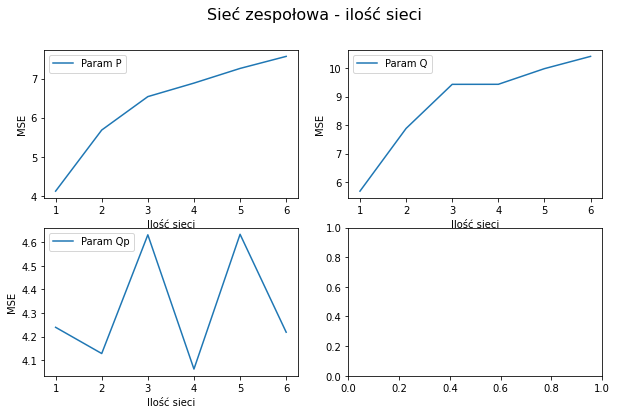

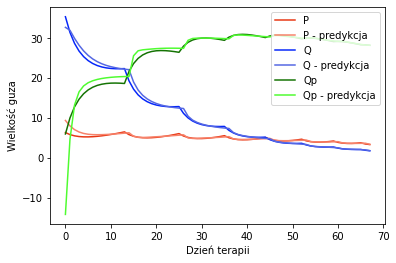

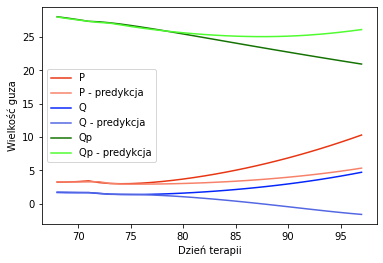

In [59]:
errors = []
number_of_groups = [1, 2, 3, 4, 5, 6]
for group in number_of_groups: 
    esn = GroupedDeepESN(input_size=3, groups=group, num_layers=((2,) * group))
    esn.fit(X, y)
    errors.append(test_esn_mse(esn, X_test, y_test))
plot_mse(number_of_groups, errors, "Sieć zespołowa - ilość sieci", "Ilość sieci")

###
esn = GroupedDeepESN(input_size=3, groups=3, num_layers=((2,) * 3), hidden_size=500)
esn.fit(X, y)
plot_esn_prediction(esn, X, y)
###
esn = GroupedDeepESN(input_size=3, groups=3, num_layers=((2,) * 3), hidden_size=500)
esn.fit(X, y)
plot_esn_prediction(esn, X_test, y_test, X.size()[0])

## Extrapolation

In [49]:
def merge_base_with_extrapolated(X, y, y_test, extrapolated):
    training_size = y_test.size()[0]
    
    predicted = np.vstack([X.detach().numpy()[-training_size:,:], extrapolated.detach().numpy()])
    true = np.vstack([y.detach().numpy()[-training_size:,:], y_test.detach().numpy()])
    
    return predicted, true

def plot_extrapolation(esn, X, y, y_test):
    extrapolation = extrapolate(esn, X_test, y_test)
    
    extrapolation, true = merge_base_with_extrapolated(X, y, y_test, extrapolation)
    
    plt.axvline(x = true.shape[0] // 2, color = 'g', label = 'ekstrapolacja')
                                                       
    x_range = range(true.shape[0])
    plt.xlabel("Dzień terapii")
    plt.ylabel("Wielkość guza")
    
    plt.plot(x_range, true.T[0], label="P", color="#e83613")
    plt.plot(x_range, extrapolation.T[0], label="P - ekstrapolacja", color="#f7826a")
    
    plt.plot(x_range, true.T[1], label="Q", color="#0526fa")
    plt.plot(x_range, extrapolation.T[1], label="Q - ekstrapolacja", color="#5467e3")
    
    plt.plot(x_range, true.T[2], label="Qp", color="#147303")
    plt.plot(x_range, extrapolation.T[2], label="Qp - ekstrapolacja", color="#4ffc30")
    plt.legend()
    plt.show()

In [60]:
X, X_test, y, y_test = select_train_and_test(df, 0.4)

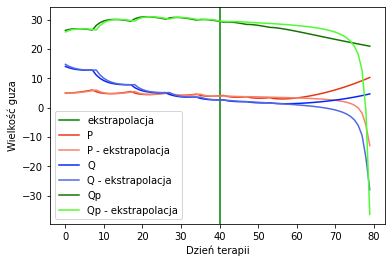

In [61]:
esn = GroupedDeepESN(input_size=3, groups=4, num_layers=((2,) * 4))
esn.fit(X, y)

#extrapolation = extrapolate(esn, X_test, y_test)
plot_extrapolation(esn, X, y, y_test)

## Sumaryczna wielkość guza

In [17]:

if "Sum" in df:
    del df['Sum']

df['Sum'] = df.sum(axis=1)
print(df)
X, X_test, y, y_test = select_train_and_test(df[["Sum"]])

            P          Q         Qp        Sum
0    7.130000  41.200000   0.000000  48.330000
1    6.313421  35.400820   5.960690  47.674932
2    5.801847  31.468446   9.976719  47.247012
3    5.489132  28.729865  12.747051  46.966048
4    5.312580  26.786594  14.687220  46.786394
..        ...        ...        ...        ...
95   8.707422   3.869566  21.713784  34.290772
96   9.219529   4.134234  21.459521  34.813284
97   9.751675   4.414845  21.207881  35.374401
98  10.303522   4.711931  20.958893  35.974347
99  10.874621   5.026020  20.712579  36.613220

[100 rows x 4 columns]


In [18]:
def plot_simple_esn_prediction(esn, X, y, offset=0):

    predicted = esn(X)
    x_range = range(offset, X.size()[0] + offset)
    plt.xlabel("Dzień terapii")
    plt.ylabel("Wielkość guza")
    
    plt.plot(x_range, y.T[0], label="P", color="#e83613")
    plt.plot(x_range, predicted.T[0], label="P - predykcja", color="#f7826a")
    
    plt.legend()
    plt.show()

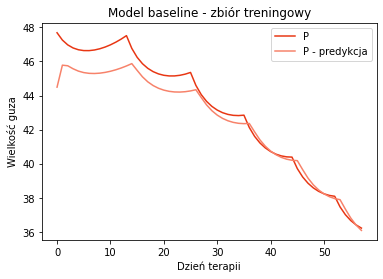

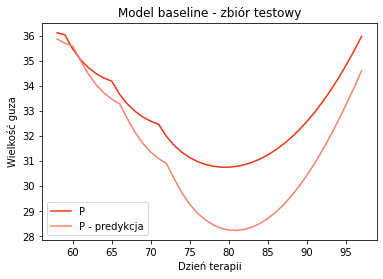

In [19]:
esn = DeepESN(input_size=1, num_layers=3)
esn.fit(X, y)

plt.title("Model baseline - zbiór treningowy")
plot_simple_esn_prediction(esn, X, y)

esn = DeepESN(input_size=1, num_layers=3)
esn.fit(X, y)
plt.title("Model baseline - zbiór testowy")
plot_simple_esn_prediction(esn, X_test, y_test, X.size()[0])


## Break

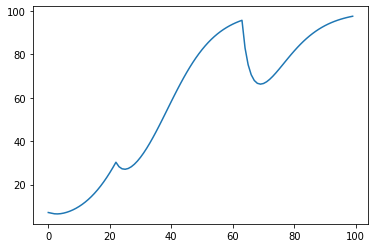

In [20]:
from Models import baseline_raw_simple_model, baseline_ribba_hyperparams, initial_tuple_ribba, initial_tuple_simple
from therapy import Therapy, gliomas_simple_strategy
time_range = np.linspace(0, 100, 100)

therapy = Therapy(baseline_raw_simple_model, gliomas_simple_strategy)
therapy.compute_therapy(time_range, initial_tuple_simple)
res = therapy.results

plt.plot(res["P"])

P = res["P"]
df = pd.DataFrame(np.array([P]).T, columns=["P"])
X, X_test, y, y_test = select_train_and_test(df)

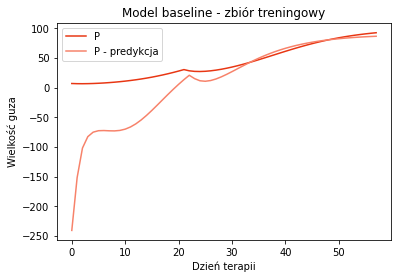

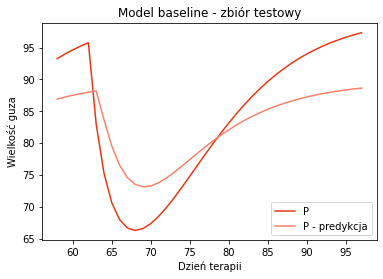

In [21]:
esn = DeepESN(input_size=1, num_layers=3)
esn.fit(X, y)

plt.title("Model baseline - zbiór treningowy")
plot_simple_esn_prediction(esn, X, y)

esn = DeepESN(input_size=1, num_layers=3)
esn.fit(X, y)
plt.title("Model baseline - zbiór testowy")
plot_simple_esn_prediction(esn, X_test, y_test, X.size()[0])